# Random forest for Visa

In [1]:
class RandomForest():
    def __init__(self, x, y, n_trees, n_features, sample_sz, depth=10, min_leaf=5):
        np.random.seed(12)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
#         print(self.n_features, "sha: ",x.shape[1])    
        self.x, self.y, self.sample_sz, self.depth, self.min_leaf  = x, y, sample_sz, depth, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], self.n_features, f_idxs,
                    idxs=np.array(range(self.sample_sz)),depth = self.depth, min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs,idxs,depth=10, min_leaf=5):
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
#         print(f_idxs)
#         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth-1, min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth-1, min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf') or self.depth <= 0 
    

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DatetimeIndex
import math
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
my_year_month_fmt = mdates.DateFormatter('%m/%y')
plt.rcParams['figure.figsize'] = (15, 9)
from datetime import datetime
import datetime
import pandas_datareader as web

In [46]:
start = datetime.datetime(2016,3,1)
end = datetime.datetime(2022,3,31)
df_visa = web.DataReader('V', 'yahoo', start, end) 

In [47]:
visa_df = df_visa
visa_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-03-01,74.639999,72.900002,72.989998,74.639999,8705300.0,71.743286
2016-03-02,74.599998,73.660004,74.500000,74.300003,5739100.0,71.416473
2016-03-03,74.500000,73.360001,74.480003,73.910004,6588300.0,71.041618
2016-03-04,74.250000,73.610001,74.220001,73.900002,9475300.0,71.031998
2016-03-07,73.449997,71.349998,73.389999,71.940002,16671900.0,69.148071


In [48]:
visa_df=visa_df.reset_index()
visa_df['Date'] = pd.to_datetime(visa_df['Date'])
visa_df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-03-01,74.639999,72.900002,72.989998,74.639999,8705300.0,71.743286
1,2016-03-02,74.599998,73.660004,74.500000,74.300003,5739100.0,71.416473
2,2016-03-03,74.500000,73.360001,74.480003,73.910004,6588300.0,71.041618
3,2016-03-04,74.250000,73.610001,74.220001,73.900002,9475300.0,71.031998
4,2016-03-07,73.449997,71.349998,73.389999,71.940002,16671900.0,69.148071
...,...,...,...,...,...,...,...
1529,2022-03-25,218.929993,215.690002,218.419998,218.429993,5051400.0,218.429993
1530,2022-03-28,220.979996,217.509995,218.500000,220.770004,4316800.0,220.770004
1531,2022-03-29,228.809998,223.779999,224.839996,228.119995,8032500.0,228.119995
1532,2022-03-30,226.160004,222.729996,225.839996,223.949997,7084000.0,223.949997


In [49]:
visa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1534 non-null   datetime64[ns]
 1   High       1534 non-null   float64       
 2   Low        1534 non-null   float64       
 3   Open       1534 non-null   float64       
 4   Close      1534 non-null   float64       
 5   Volume     1534 non-null   float64       
 6   Adj Close  1534 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 84.0 KB


In [51]:
start = datetime.datetime(2016,3,1)
end = datetime.datetime(2022,3,31)
gspc = web.DataReader('^GSPC', 'yahoo', start, end) 
snp = gspc
snp.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-03-01,1978.349976,1937.089966,1937.089966,1978.349976,4819750000,1978.349976
2016-03-02,1986.510010,1968.800049,1976.599976,1986.449951,4666610000,1986.449951
2016-03-03,1993.689941,1977.369995,1985.599976,1993.400024,5081700000,1993.400024
2016-03-04,2009.130005,1986.770020,1994.010010,1999.989990,6049930000,1999.989990
2016-03-07,2006.119995,1989.380005,1996.109985,2001.760010,4968180000,2001.760010


In [52]:
snp=snp.reset_index()
snp['Date'] = pd.to_datetime(snp['Date'])
snp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1534 non-null   datetime64[ns]
 1   High       1534 non-null   float64       
 2   Low        1534 non-null   float64       
 3   Open       1534 non-null   float64       
 4   Close      1534 non-null   float64       
 5   Volume     1534 non-null   int64         
 6   Adj Close  1534 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 84.0 KB


In [53]:
snp.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2016-03-01,1978.349976,1937.089966,1937.089966,1978.349976,4819750000,1978.349976
1,2016-03-02,1986.510010,1968.800049,1976.599976,1986.449951,4666610000,1986.449951
2,2016-03-03,1993.689941,1977.369995,1985.599976,1993.400024,5081700000,1993.400024
3,2016-03-04,2009.130005,1986.770020,1994.010010,1999.989990,6049930000,1999.989990
4,2016-03-07,2006.119995,1989.380005,1996.109985,2001.760010,4968180000,2001.760010


In [54]:
visa_df.index=DatetimeIndex(visa_df['Date'])
snp.index=DatetimeIndex(snp['Date'])

In [55]:
X = visa_df
print(X)

                 Date        High         Low        Open       Close  \
Date                                                                    
2016-03-01 2016-03-01   74.639999   72.900002   72.989998   74.639999   
2016-03-02 2016-03-02   74.599998   73.660004   74.500000   74.300003   
2016-03-03 2016-03-03   74.500000   73.360001   74.480003   73.910004   
2016-03-04 2016-03-04   74.250000   73.610001   74.220001   73.900002   
2016-03-07 2016-03-07   73.449997   71.349998   73.389999   71.940002   
...               ...         ...         ...         ...         ...   
2022-03-25 2022-03-25  218.929993  215.690002  218.419998  218.429993   
2022-03-28 2022-03-28  220.979996  217.509995  218.500000  220.770004   
2022-03-29 2022-03-29  228.809998  223.779999  224.839996  228.119995   
2022-03-30 2022-03-30  226.160004  222.729996  225.839996  223.949997   
2022-03-31 2022-03-31  225.919998  220.440002  223.910004  221.770004   

                Volume   Adj Close  
Date         

In [56]:
X['Stock_Price'] = (2*visa_df.High + visa_df.Low + visa_df.Close)/4
X['Stock_Price']

Date
2016-03-01     74.205000
2016-03-02     74.290001
2016-03-03     74.067501
2016-03-04     74.002501
2016-03-07     72.547499
                 ...    
2022-03-25    217.994995
2022-03-28    220.059998
2022-03-29    227.379997
2022-03-30    224.750000
2022-03-31    223.512501
Name: Stock_Price, Length: 1534, dtype: float64

In [57]:
snp['High']

Date
2016-03-01    1978.349976
2016-03-02    1986.510010
2016-03-03    1993.689941
2016-03-04    2009.130005
2016-03-07    2006.119995
                 ...     
2022-03-25    4546.029785
2022-03-28    4575.649902
2022-03-29    4637.299805
2022-03-30    4627.770020
2022-03-31    4603.069824
Name: High, Length: 1534, dtype: float64

In [58]:
X['SP500'] = (2*snp.High + snp.Low + snp.Close)/4
X

,Date,High,Low,Open,Close,Volume,Adj Close,Stock_Price,SP500
Date,,,,,,,,,
2016-03-01,2016-03-01,74.639999,72.900002,72.989998,74.639999,8705300.0,71.743286,74.205000,1968.034973
2016-03-02,2016-03-02,74.599998,73.660004,74.500000,74.300003,5739100.0,71.416473,74.290001,1982.067505
2016-03-03,2016-03-03,74.500000,73.360001,74.480003,73.910004,6588300.0,71.041618,74.067501,1989.537476
2016-03-04,2016-03-04,74.250000,73.610001,74.220001,73.900002,9475300.0,71.031998,74.002501,2001.255005
2016-03-07,2016-03-07,73.449997,71.349998,73.389999,71.940002,16671900.0,69.148071,72.547499,2000.845001
...,...,...,...,...,...,...,...,...,...
2022-03-25,2022-03-25,218.929993,215.690002,218.419998,218.429993,5051400.0,218.429993,217.994995,4534.047363
2022-03-28,2022-03-28,220.979996,217.509995,218.500000,220.770004,4316800.0,220.770004,220.059998,4561.127441
2022-03-29,2022-03-29,228.809998,223.779999,224.839996,228.119995,8032500.0,228.119995,227.379997,4623.964966


In [59]:
from sklearn.preprocessing import StandardScaler
col_names = ['SP500']
features = X[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [60]:
X[col_names] = features

In [61]:
X.drop(columns=['Date', 'Open', 'High', 'Low', 'Close','Adj Close'],inplace=True)

In [62]:
X.head()

,Volume,Stock_Price,SP500
Date,,,
2016-03-01,8705300.0,74.205000,-1.424271
2016-03-02,5739100.0,74.290001,-1.405634
2016-03-03,6588300.0,74.067501,-1.395713
2016-03-04,9475300.0,74.002501,-1.380150
2016-03-07,16671900.0,72.547499,-1.380695


Text(0, 0.5, 'Stock_Price')

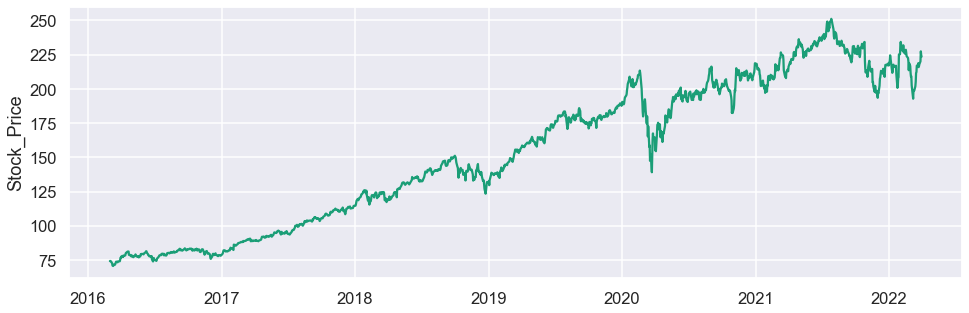

In [63]:
fig, (ax1) = plt.subplots(1, 1, figsize=(16,5))
ax1.plot(X.index,X['Stock_Price'])
ax1.set_ylabel('Stock_Price')

In [64]:
y = X.Stock_Price

In [65]:
X.drop(['Stock_Price'],inplace = True,axis=1)

In [93]:
rf = RandomForest(x=X,y=y,n_trees=30,n_features=3,sample_sz=1000)

In [ ]:
# hyperparameters

In [94]:
tree = rf.create_tree()

In [96]:
y_pred = rf.predict(X.tail(300).values)

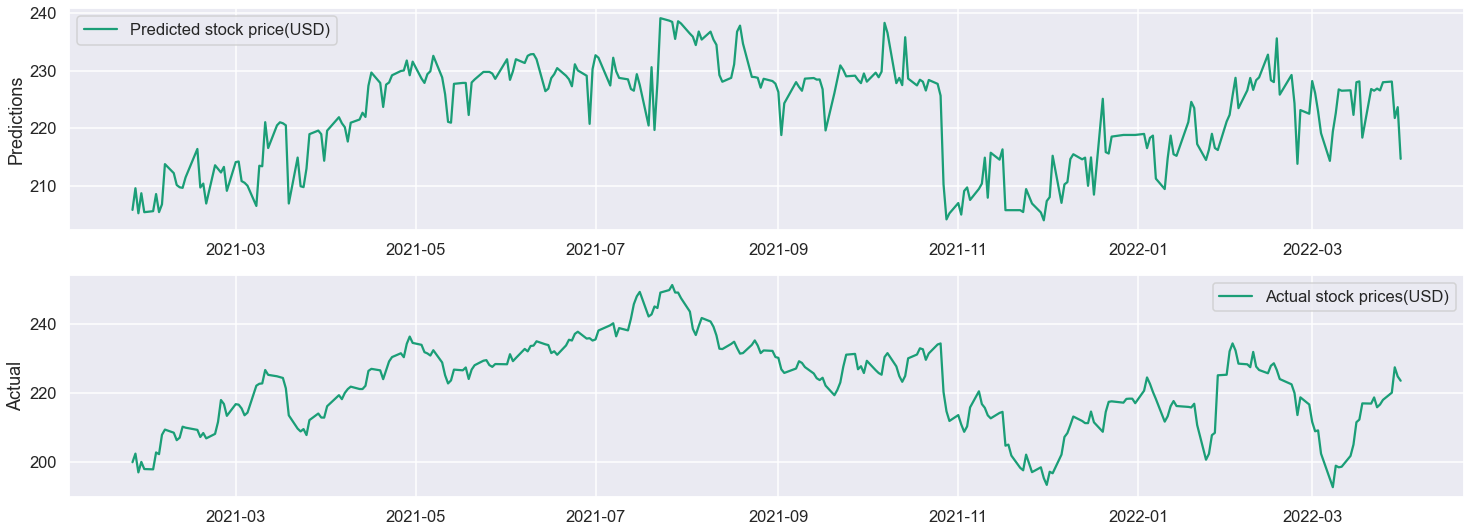

In [97]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25,9))
ax1.plot(X.tail(300).index,y_pred,label="Predicted stock price(USD)")
ax1.set_ylabel("Predictions")
ax2.set_ylabel("Actual")
ax1.legend(loc='best')
ax2.plot(X.tail(300).index,y.tail(300),label="Actual stock prices(USD)")
ax2.legend(loc='best')

In [101]:
# exponential weighted functions
ema_short = X.ewm(span=7, adjust=False).mean()

In [102]:
y_short = y.ewm(span=7, adjust=False).mean()

In [103]:
rf2 = RandomForest(x=ema_short,y=y_short,n_trees=30,n_features=3,sample_sz=1000)

In [104]:
y_pred_short = rf.predict(ema_short.tail(300).values)

In [105]:
rf2.create_tree()

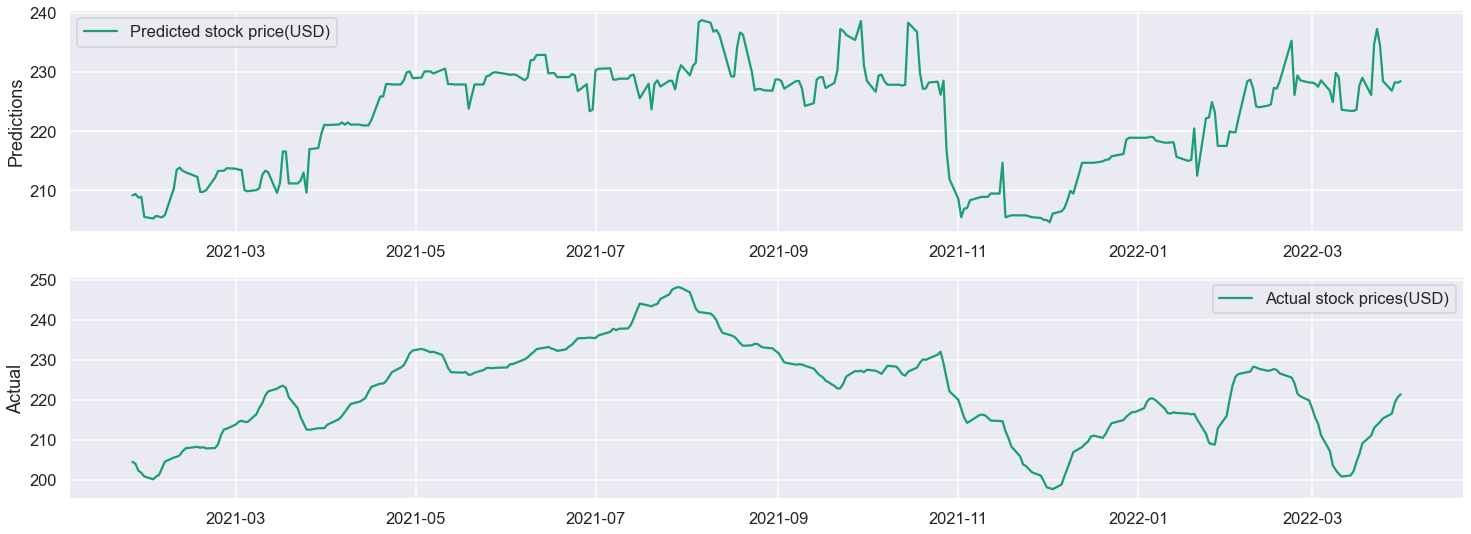

In [106]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25,9))
ax1.plot(ema_short.tail(300).index,y_pred_short,label="Predicted stock price(USD)")
ax2.plot(X.tail(300).index,y_short.tail(300),label="Actual stock prices(USD)")
ax1.set_ylabel("Predictions")
ax2.set_ylabel("Actual")
ax1.legend(loc='best')
ax2.legend(loc='best')

In [107]:
trading_signal_week = pd.DataFrame(np.sign(np.diff(y_pred_short)),index=X.tail(299).index,columns=["signal"])

In [108]:
trading_signal_week.head()

,signal
Date,
2021-01-26,1.0
2021-01-27,-1.0
2021-01-28,1.0
2021-01-29,-1.0
2021-02-01,-1.0


In [109]:
X.head()

,Volume,SP500
Date,,
2016-03-01,8705300.0,-1.424271
2016-03-02,5739100.0,-1.405634
2016-03-03,6588300.0,-1.395713
2016-03-04,9475300.0,-1.380150
2016-03-07,16671900.0,-1.380695


In [110]:
trading_signal_week = trading_signal_week.shift(1)

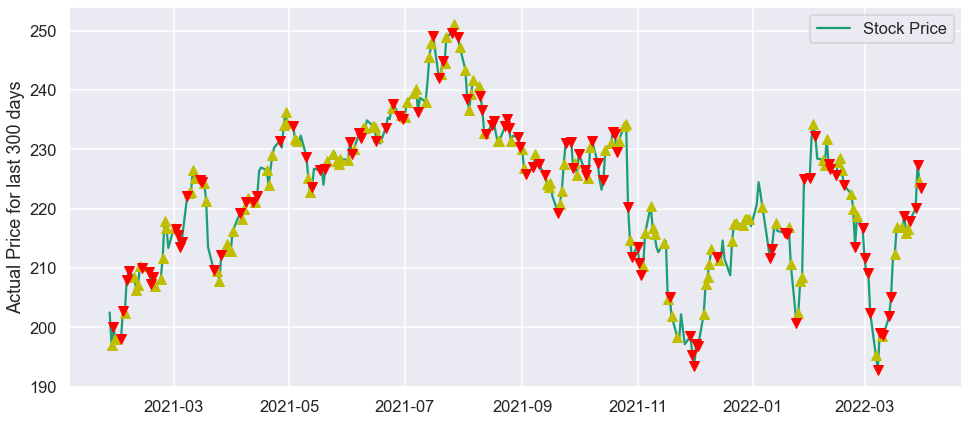

In [111]:
fig, (ax2) = plt.subplots(1, 1, figsize=(16,7))
duration = 299
y_temp = pd.DataFrame(y_short.tail(duration),index =X.tail(duration).index)
ax2.plot(X.tail(duration).index,y.tail(duration),label="Stock Price")

ax2.set_ylabel("Actual Price for last 300 days")

ax2.legend(loc='best')

# # Plot the buy signals
ax2.plot(trading_signal_week.tail(duration).loc[trading_signal_week.signal == 1.0].index, 
         y.tail(duration)[trading_signal_week.signal == 1.0],'^', markersize=10, color='y')

# Plot the sell signals
ax2.plot(trading_signal_week.tail(duration).loc[trading_signal_week.signal == -1.0].tail(duration).index, 
         y.tail(duration)[trading_signal_week.signal == -1.0],'v', markersize=10, color='r')

In [112]:
trading_signal_week['signal'].unique()

array([nan,  1., -1.,  0.])

In [113]:
# Set the initial capital
initial_capital= float(10000.0)

# Create a DataFrame 'positions'
positions = pd.DataFrame(index=trading_signal_week.index).fillna(0.0)

# Buy
positions['stock_price'] = trading_signal_week['signal'] 
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(y_short.tail(300), axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add 'holdings' to portfolio
portfolio['holdings'] = (positions.multiply(y_short.tail(300), axis=0)).sum(axis=1)

# Add 'cash' to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(y_short.tail(300), axis=0)).sum(axis=1).cumsum()   

# Add 'total' & 'returns' to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

portfolio['returns'] = portfolio['total'].pct_change()

In [114]:
portfolio = portfolio.loc["2019-08-01":]

In [115]:
portfolio

,stock_price,holdings,cash,total,returns
Date,,,,,
2021-01-25,NaN,0.000000,10000.000000,10000.000000,NaN
2021-01-26,NaN,0.000000,10000.000000,10000.000000,0.000000
2021-01-27,202.233643,202.233643,10000.000000,10202.233643,0.020223
2021-01-28,-201.699607,-201.699607,10403.399214,10201.699607,-0.000052
2021-01-29,200.784705,200.784705,10001.829803,10202.614508,0.000090
...,...,...,...,...,...
2022-03-25,-215.309501,-215.309501,10467.386365,10252.076864,0.000087
2022-03-28,-216.497125,-216.497125,10467.386365,10250.889240,-0.000116
2022-03-29,-219.217843,-219.217843,10467.386365,10248.168522,-0.000265


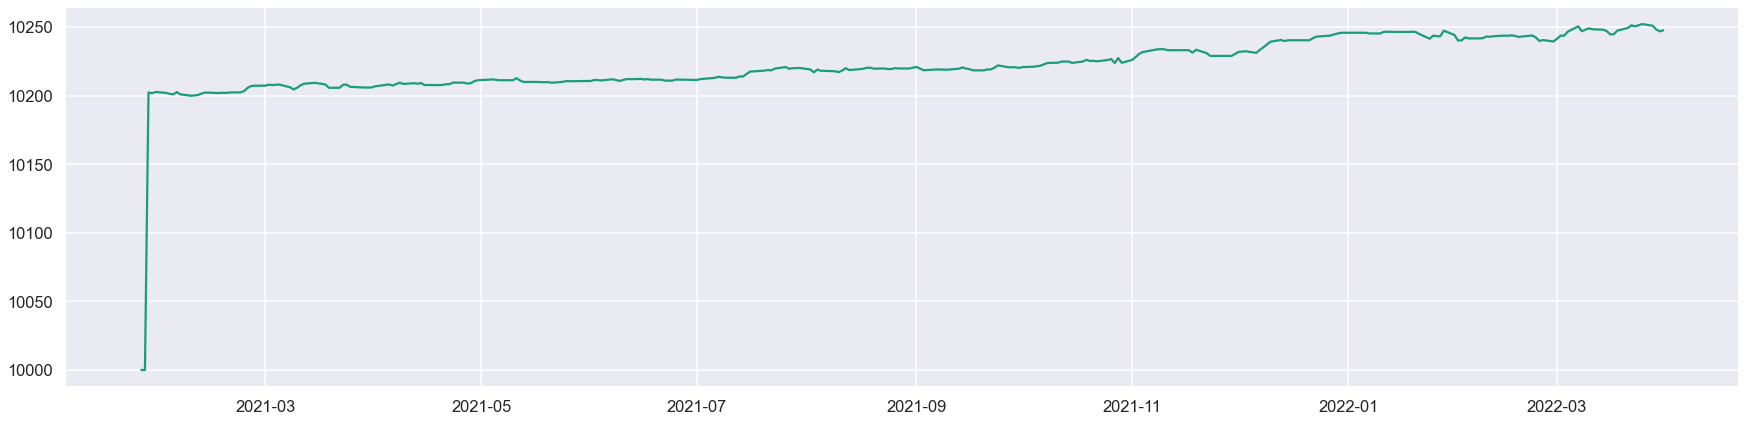

In [116]:
fig, ax1 = plt.subplots(1, 1, figsize=(30,7))
duration = 299
ax1.plot(portfolio['total'])

In [117]:
# Isolate the returns of the strategy
returns = portfolio['returns']
print(returns)
# 90 day Sharpe ratio
#sharpe_ratio = np.sqrt(90) * (returns.mean() / returns.std())

# Print the Sharpe ratio
#print(sharpe_ratio)

Date
2021-01-25         NaN
2021-01-26    0.000000
2021-01-27    0.020223
2021-01-28   -0.000052
2021-01-29    0.000090
                ...   
2022-03-25    0.000087
2022-03-28   -0.000116
2022-03-29   -0.000265
2022-03-30   -0.000135
2022-03-31    0.000071
Name: returns, Length: 300, dtype: float64


In [119]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_short.tail(300), y_pred_short))

In [120]:
rms

8.095705177207964